In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import randrange
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
import sys
import time
from time import time

## K-Means Preparinator
A notebook to compute silhouette scores and identify the best k. Part of the DUNE project (https://github.com/opendr-io/dune) for hunting threats that are resistant to conventional detection. The examples below are for analysis of CloudTrail logs; refactor as needed.


In [3]:
# input file - or you can ingest directly from S3 using the boto3 module'
# if you do that at great scale, you might run the notebook in the same region
# as the bucket to avoid egress charges
csv_file_path = 'cloudtrail.csv'

In [4]:
# Read the file and extract relevant fields
raw = pd.read_csv(csv_file_path, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
print('raw data shape and column names:')
print(raw.shape)
df = raw.copy()

raw data shape and column names:
(25675, 9)


In [5]:
# Read the file and extract relevant fields
raw = pd.read_csv(csv_file_path, encoding='utf-8', low_memory=False)  # Adjust the encoding if needed
print('raw data shape and column names:')
print(raw.shape)

raw data shape and column names:
(25675, 9)


In [6]:
cardinality = (
    df.nunique(dropna=True)
      .sort_values(ascending=False)
)
print('Choose your fields:')
print(cardinality)

Choose your fields:
eventid             25675
timestamp           17394
eventName              75
sourceIPAddress        47
userAgent              28
eventSource            19
tactic1                 6
userIdentity.arn        3
tactic2                 3
dtype: int64


In [7]:
# Select fields to encode
fields_to_encode = [  'userAgent', 'eventName', 'userIdentity.arn' ]
# Select the columns you want to use for outlier detection
columns_for_outliers = [  'userAgent', 'eventName', 'userIdentity.arn' ] 

In [8]:
# print statistical summary, useful in assesing balance 
for field in fields_to_encode:
    print(field)
    print(df[field].value_counts().describe())
    print("==============")

userAgent
count       28.000000
mean       916.964286
std       4122.901248
min          1.000000
25%          1.000000
50%          2.500000
75%         10.750000
max      21730.000000
Name: count, dtype: float64
eventName
count       75.000000
mean       342.333333
std       2505.527421
min          1.000000
25%          3.500000
50%         10.000000
75%         39.000000
max      21730.000000
Name: count, dtype: float64
userIdentity.arn
count        3.000000
mean      8558.333333
std      11575.603411
min          4.000000
25%       1972.500000
50%       3941.000000
75%      12835.500000
max      21730.000000
Name: count, dtype: float64


In [9]:
#convert to categorical type and then to integers 
for field in fields_to_encode:
    df[field] = df[field].astype('category')
    df[field] = df[field].cat.codes

In [10]:
#remove the mean and scale each feature/variable to unit variance
x = df.loc[:, columns_for_outliers].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [11]:
pca_2 = PCA(n_components=2)
X2 = pca_2.fit_transform(x)
#reduce dimensionality of the data so we can plot it

In [12]:
# scale numerical data in a pandas DataFrame using the StandardScaler 
df_scaled = df[fields_to_encode].copy()
df_scaled[df_scaled.columns] = StandardScaler().fit_transform(df_scaled)
print(df_scaled.describe())

# creates a PCA object configured to reduce the dataset to two dimensions. 
# The parameter n_components=2 keeps the two most significant
# principal components.

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
    np.sum(pca_2.explained_variance_ratio_)))

# Results from pca.components_
# create a new DataFrame, dataset_pca, from the absolute values
# of the components_ attribute of the pca_2 object. 
# The rows of this DataFrame correspond to the principal components (PC_1 and PC_2),
# and the columns correspond to the original features from df_scaled.
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2'])

print('\n\n', dataset_pca)
# filter the components, retaining only those loadings that are greater
# than 0.3, indicating a substantial contribution to the variance captured 
# by the principal component.iloc[0] and .iloc[1] are used to select 
# the respective rows for PC_1 and PC_2. dropna() is applied to remove any 
# features that do not meet the threshold, simplifying the output to only
# include relevant features.
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")

          userAgent     eventName  userIdentity.arn
count  2.567500e+04  2.567500e+04      2.567500e+04
mean   2.302518e-16  3.542336e-17      1.062701e-16
std    1.000019e+00  1.000019e+00      1.000019e+00
min   -1.474429e+01 -4.720562e-01     -4.258282e-01
25%    2.925041e-01 -3.890513e-01     -4.258282e-01
50%    2.925041e-01 -3.890513e-01     -4.258282e-01
75%    2.925041e-01 -3.890513e-01     -4.258282e-01
max    2.925041e-01  5.670306e+00      5.111340e+00
Explained variation per principal component: [0.83900583 0.13166566]
Cumulative variance explained by 2 principal components: 97.07%


       userAgent  eventName  userIdentity.arn
PC_1   0.534081   0.595863          0.599754
PC_2   0.844879   0.401858          0.353115

*************** Most important features *************************
As per PC 1:
 userAgent           0.534081
eventName           0.595863
userIdentity.arn    0.599754
Name: PC_1, dtype: float64


As per PC 2:
 userAgent           0.844879
eventName           0

In [13]:
df_scaled

,userAgent,eventName,userIdentity.arn
0,0.292504,-0.389051,-0.425828
1,0.292504,-0.389051,-0.425828
2,0.292504,-0.389051,-0.425828
3,0.292504,-0.389051,-0.425828
4,0.292504,-0.389051,-0.425828
...,...,...,...
25670,-1.378251,5.504297,2.342756
25671,-1.378251,5.587301,2.342756
25672,-1.378251,5.587301,2.342756
25673,-1.378251,5.587301,2.342756


In [14]:
print(dataset_pca)

      userAgent  eventName  userIdentity.arn
PC_1   0.534081   0.595863          0.599754
PC_2   0.844879   0.401858          0.353115


Parameter: {'n_clusters': 2} Score 0.9443270670065702
Parameter: {'n_clusters': 3} Score 0.9547217916298876
Parameter: {'n_clusters': 4} Score 0.9434221413202005
Parameter: {'n_clusters': 5} Score 0.9464063943015174
Parameter: {'n_clusters': 6} Score 0.9474271606944225
Parameter: {'n_clusters': 7} Score 0.9477730615681881
Parameter: {'n_clusters': 8} Score 0.9514454516074153
Parameter: {'n_clusters': 9} Score 0.9517975166109905
Parameter: {'n_clusters': 10} Score 0.9486479049853597
Parameter: {'n_clusters': 11} Score 0.9504111287757914
Parameter: {'n_clusters': 12} Score 0.9541346427597914
Parameter: {'n_clusters': 13} Score 0.9540640085145208
Parameter: {'n_clusters': 14} Score 0.9547544270582898
Parameter: {'n_clusters': 15} Score 0.9566120300023591
Parameter: {'n_clusters': 16} Score 0.9569343369256316
Parameter: {'n_clusters': 17} Score 0.9589976228966952
Parameter: {'n_clusters': 18} Score 0.9536948483822623
Parameter: {'n_clusters': 19} Score 0.9613255302497107
Parameter: {'n_clu

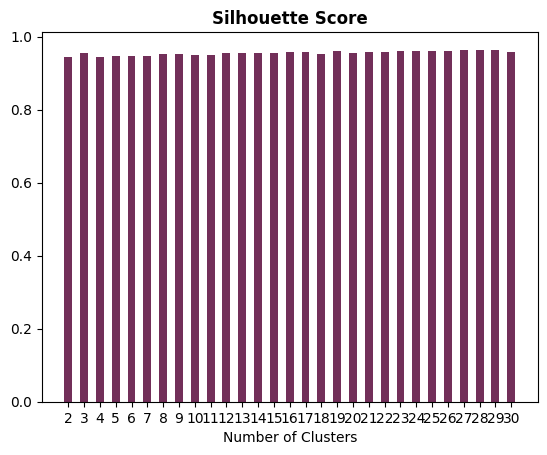

28


In [15]:
# candidate values for our number of cluster
#parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
parameters = list(range(2, 31))

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})

best_score = -1
#kmeans_model = KMeans()   # instantiating KMeans model
kmeans_model = KMeans(n_init=20, random_state=42)

silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(df_scaled)          # fit model on wine dataset, this will find clusters based on parameter p

    ss = metrics.silhouette_score(df_scaled, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores

    print('Parameter:', p, 'Score', ss)

    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

optimum_num_clusters = best_grid['n_clusters']
print(best_grid['n_clusters'])

In [16]:
 # fitting KMeans
print ('Fitting..')
kmeans_n = KMeans(n_clusters=optimum_num_clusters)
kmeans_n.fit(df_scaled)
centroids = kmeans_n.cluster_centers_
centroids_pca = pca_2.transform(centroids)
print("Optimum number of clusters= "+ str(optimum_num_clusters))

Fitting..
Optimum number of clusters= 28


D:\testing\dune\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [17]:
# quick test to measure stability and choose an init number
inertias = []
x_for_kmeans = pca_2_result   # shape (n_samples, 2)

for i in range(30):
    km = KMeans(
        n_clusters=optimum_num_clusters,
        n_init=1,
        random_state=i
    )
    km.fit(x_for_kmeans)
    inertias.append(km.inertia_)

print("Stddev:", np.std(inertias))
print("Mean:", np.mean(inertias))
print("Ratio:", np.std(inertias)/np.mean(inertias))


Stddev: 2.4586923274778196
Mean: 40.968597450384195
Ratio: 0.060014071276310255


In [18]:
# another test to measure stability and choose an init number 
inertias = []
for i in range(30):
    km = KMeans(n_clusters=optimum_num_clusters, n_init=10, random_state=i)
    km.fit(x_for_kmeans)
    inertias.append(km.inertia_)

print("Stddev:", np.std(inertias))
print("Mean:", np.mean(inertias))
print("Ratio:", np.std(inertias)/np.mean(inertias))


Stddev: 0.894158948599258
Mean: 38.17629992981368
Ratio: 0.023421833709478142
